Circular data, such as data that represents angles, directions or timestamps, can present unique challenges when it comes to analysis and modeling. The nature of the circular data can cause difficulties when trying to apply traditional linear and kernel-based methods, as these methods are not well suited to handle the periodic nature of circular data. Additionally, circular data can also raise issues when trying to compute mean and standard deviation, as these measures are not well-defined for circular data.

**PyCircular** addresses these challenges by providing a set of tools and functionality specifically tailored for working with circular data. The library includes a variety of circular statistical methods, including distributions, kernels, and confidence intervals. Additionally, it also includes visualization tools such as circular histograms and distribution plots, to help you better understand your data.

In [1]:
import pandas as pd
import pycircular

df = pycircular.datasets.load_transactions()["data"]
df["date"] = pd.to_datetime(df["date"])
dates = df.loc[df["user"] == 1, "date"]

In [2]:
df

,user,type,amt,date
1,1,1,-0.334,2020-01-01 03:09:57
5,2,1,-0.238,2020-01-01 04:01:43
6,1,1,-0.247,2020-01-01 16:37:52
9,1,2,0.537,2020-01-01 19:16:12
12,1,2,0.537,2020-01-01 19:16:58
...,...,...,...,...
102,2,2,-0.079,2020-07-25 20:41:20
103,2,1,-0.030,2020-07-25 22:37:33
104,1,1,-0.077,2020-07-27 02:34:13
107,2,2,0.541,2020-07-27 02:35:54


In [3]:
dates.head()

1    2020-01-01 03:09:57
6    2020-01-01 16:37:52
9    2020-01-01 19:16:12
12   2020-01-01 19:16:58
15   2020-01-01 19:17:48
Name: date, dtype: datetime64[ns]

In [4]:
dates.describe(datetime_is_numeric=True)

count                              349
mean     2020-04-03 01:32:31.352435712
min                2020-01-01 03:09:57
25%                2020-02-09 08:44:55
50%                2020-03-27 01:00:01
75%                2020-05-25 00:36:32
max                2020-07-29 22:39:35
Name: date, dtype: object

<AxesSubplot: xlabel='date'>

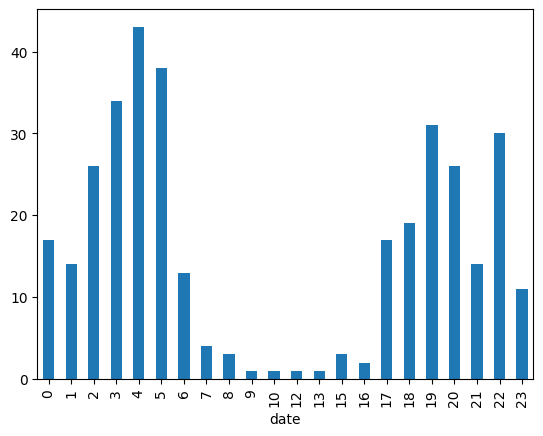

In [5]:
dates.groupby(dates.dt.hour).count().plot(kind="bar")

Plotting a histogram of the time of each observation, we see that most examples happened between 5pm and 7am, with few happening at noon. Moreover, when dealing with hour of the day as a scalar variable, there are a few issues that can arise.

- One issue is that hour of the day is cyclical in nature, meaning that the value at the end of the day (24:00) is related to the value at the beginning of the day (00:00). However, when hour of the day is treated as a scalar variable, this cyclical relationship is not considered, which can lead to inaccurate or misleading results.
- Another issue is that hour of the day is often correlated with other variables, such as day of the week or season. For example, there may be more traffic during rush hour on a weekday than on a weekend. However, when hour of the day is treated as a scalar variable, these correlations are not considered and can lead to biased or misleading results.
- A third issue is that hour of the day can be affected by different factors such as season, day of the week, or even holidays. These factors can greatly impact the behavior and patterns of hour of the day. So, if this information is not taken into account when using hour of the day as a scalar variable, it can lead to inaccurate conclusions.

To overcome these issues, one solution is to use a cyclical encoding technique, such as sine and cosine encoding, to incorporate the cyclical nature of the data. Another solution is to include other relevant variables, such as day of the week or season, in the model to account for potential correlations. Additionally, it’s important to consider the impact of different factors on the hour of the day when analyzing data.

For our example, let's begging by using a circular histogram plot to better understand our dataset.

In [6]:
import matplotlib.pyplot as plt

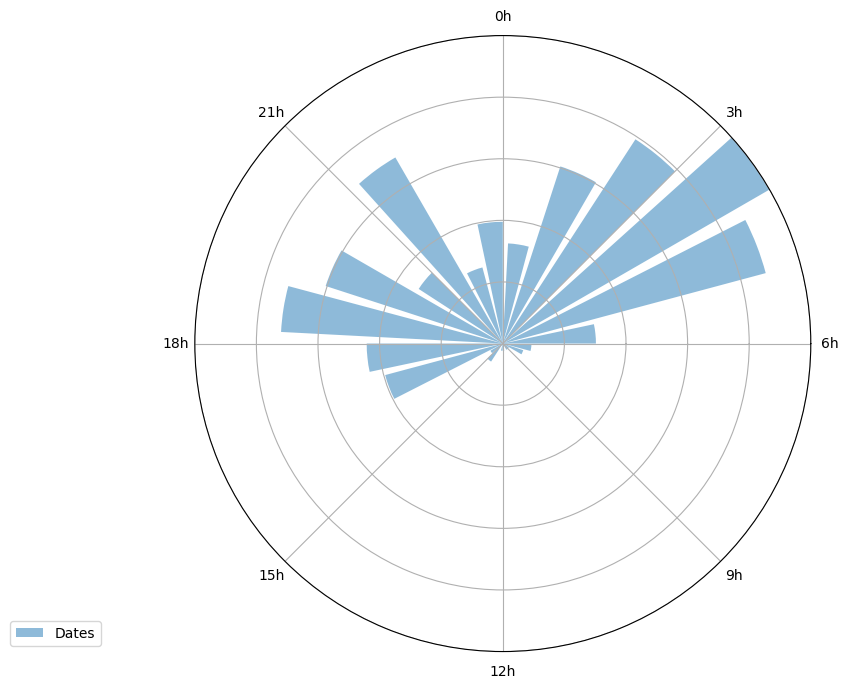

In [7]:
time_segment = "hour"  # 'hour', 'dayweek', 'daymonth
freq_arr, times = pycircular.utils.freq_time(dates, time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(
    freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment
)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Then, calculate the scalar or arithmetic mean

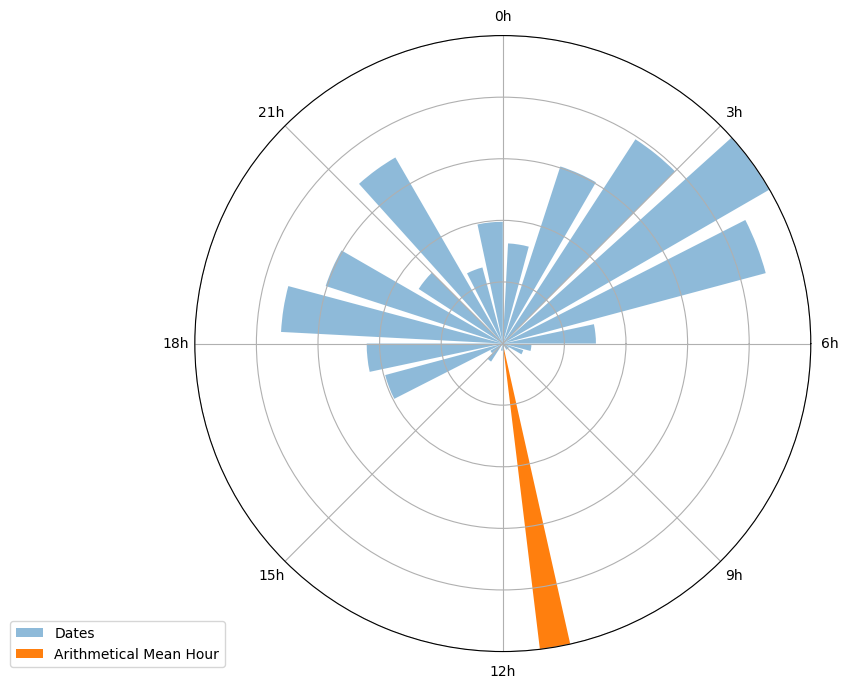

In [8]:
dates_mean = times.values.mean()
fig, ax1 = pycircular.plots.base_periodic_fig(
    freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment
)
ax1.bar([dates_mean], [1], width=0.1, label="Arithmetical Mean Hour")
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

The issue when dealing with the time of the example, specifically, when analyzing a feature such as the mean of time, is that it is easy to make the mistake of using the arithmetic mean. Indeed, the arithmetic mean is not a correct way to average time because, as shown in the above figure, it does not consider the periodic behavior of the time feature. For example, the arithmetic mean of time of four transactions made at 2:00, 3:00, 22:00 and 23:00 is 12:30, which is counter-intuitive since no were made close to that time.

We can overcome this limitation by modeling the time of the transaction as a periodic variable, in particular using the von Mises distribution (Fisher, 1996). The von Mises distribution, also known as the periodic normal distribution, is a distribution of a wrapped normal distributed variable across a circle.

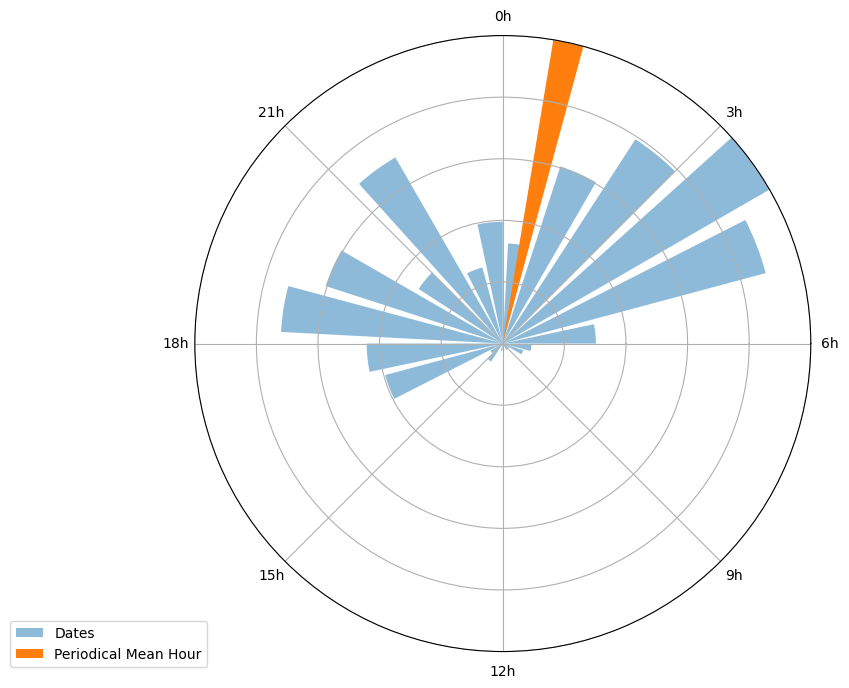

In [9]:
radians = pycircular.utils._date2rad(dates, time_segment="hour")
mean, std = pycircular.stats.periodic_mean_std(radians)

fig, ax1 = pycircular.plots.base_periodic_fig(
    freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment
)
ax1.bar([mean], [1], width=0.1, label="Periodical Mean Hour")
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Now, having calculated the periodic mean and standard deviation, we can estimate the von Mises distribution.

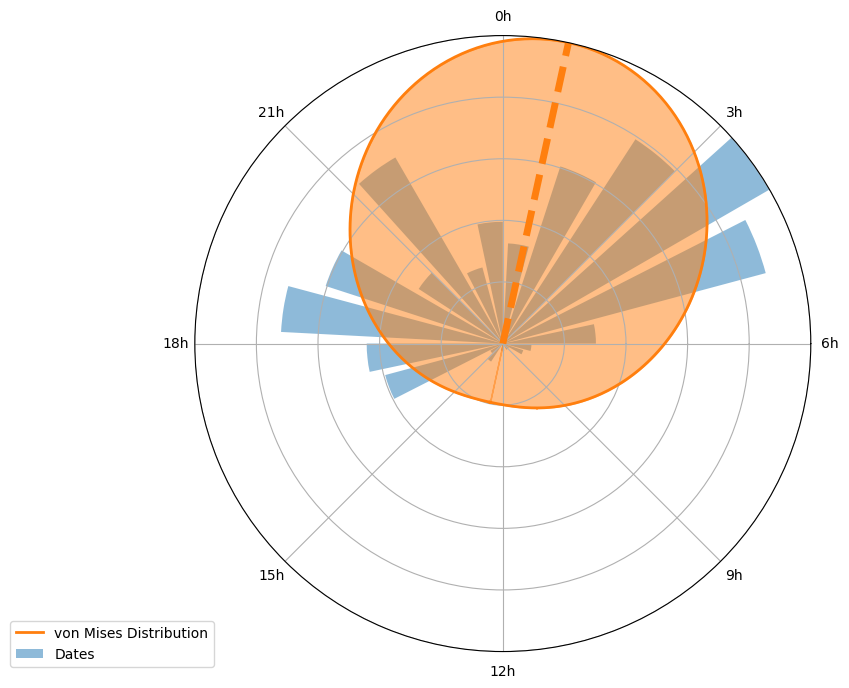

In [10]:
# Calculate the von Mises distribution
x, p = pycircular.stats.von_mises_distribution(mean, std)

fig, ax1 = pycircular.plots.base_periodic_fig(
    freq_arr[:, 0], freq_arr[:, 1], time_segment="hour"
)

ax1 = pycircular.plots.clock_vonmises_distribution(ax1, mean, x, p)
plt.show()

This method gives us a good approximation of the distribution of the time of the events. However, when using a statistical distribution with only one mode, it may be difficult to accurately model the data if the distribution is not a good fit for the data set. Additionally, if the data set is multi-modal (i.e. has multiple peaks), a single mode distribution will not be able to capture all the variations in the data. This could lead to poor predictions or inferences based on the model.

This can be overcome by modeling the data with a von Mises kernel distribution.

One way to overcome the issues of using a statistical distribution with only one mode is to use a kernel-based method, such as kernel density estimation (KDE).

KDE is a non-parametric method for estimating the probability density function of a random variable. It works by replacing the point-mass at each data point with a smooth and symmetric kernel function, such as a von Mises. The resulting estimate of the PDF is a sum of the kernel functions centered at each data point.

By using a kernel function, KDE can smooth out any single-modal distributions, and can capture multiple modes in the data, making it a more flexible method for modeling multi-modal data sets. Additionally, kernel density estimation is non-parametric, which means it does not make any assumptions about the underlying distribution of the data.

However, it’s worth noting that choosing the right kernel is important, and there are some challenges when working with KDE such as the choice of bandwidth and the curse of dimensionality.

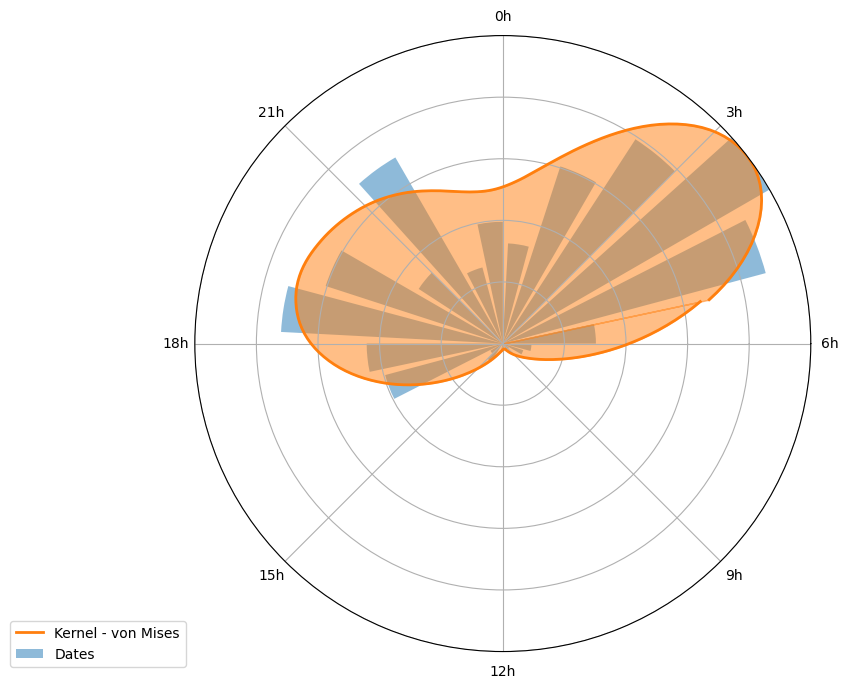

In [11]:
y = pycircular.circular.kernel(radians.values)

fig, ax1 = pycircular.plots.plot_kernel(
    freq_arr[:, 0], freq_arr[:, 1], y, time_segment=time_segment
)

In summary, using a kernel-based method such as KDE with von Mises can help overcome the issues of using a statistical distribution with only one mode by allowing for a more flexible and robust modeling of multi-modal data sets.

# Using the kernel to create a new feature

Finally, we can apply the kernel to new observations and create a new feature that can be used as an input for a machine learning model.

In [12]:
y_test = pd.DataFrame(
    pd.to_datetime(
        [
            "2023-01-01 12:00:00",
            "2023-01-01 03:00:00",
            "2023-01-01 18:00:00",
        ]
    ),
    columns=["dates"],
)

radians = pycircular.utils._date2rad(y_test["dates"], time_segment="hour")
y_test["prob"] = pycircular.circular.predict_proba(radians, y)

In [13]:
y_test

,dates,prob
0,2023-01-01 12:00:00,0.017654
1,2023-01-01 03:00:00,0.838482
2,2023-01-01 18:00:00,0.500127


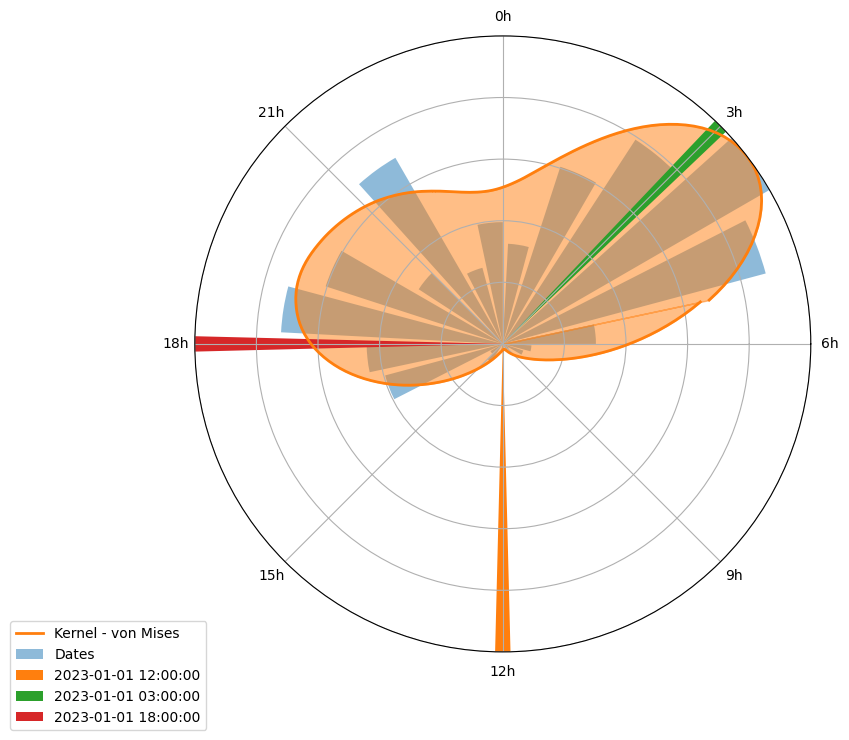

In [14]:
fig, ax1 = pycircular.plots.plot_kernel(
    freq_arr[:, 0], freq_arr[:, 1], y, time_segment=time_segment
)

for i in range(y_test.shape[0]):
    ax1.bar([radians[i]], [1], width=0.05, label=y_test.loc[i, "dates"])

ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

We can see that an observation at noon, have a very low probability (0.017) because when training the kernel, there wasn’t any observations at that time.

In conclusion, this methodology allows us to effectively deal with timestamps by creating more robust representations of the temporal information in the data. By using the kernel of von Mises during feature engineering, we can generate new features that accurately capture the nuances of temporal patterns in the data. This approach can overcome the limitations of treating dates as a scalar variable and lead to improved performance in machine learning models.